# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import os
import sys
from pathlib import Path
import time
import tempfile
import logging

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import mne
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, LocalCluster

In [2]:
from pythoneeg import core
from pythoneeg import visualization
from pythoneeg import constants

print(core.__all__)
# print(visualization.__all__)
# print(dir(constants))

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['DDFBinaryMetadata', 'LongRecordingOrganizer', 'convert_ddfcolbin_to_ddfrowbin', 'convert_ddfrowbin_to_si', 'convert_units_to_multiplier', 'convert_colpath_to_rowpath', 'filepath_to_index', 'is_day', 'set_temp_directory', 'get_temp_directory', 'parse_path_to_animalday', 'parse_str_to_genotype', 'parse_str_to_animal', 'parse_str_to_day', 'parse_chname_to_abbrev', 'nanaverage', 'LongRecordingAnalyzer', 'MountainSortAnalyzer', 'FragmentAnalyzer', '_log_transform']


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

2025-06-03 20:12:40,731 - root - INFO - Temporary directory set to /mnt/isilon/marsh_single_unit/PythonEEG/tmp


/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
data_folder = Path('./test-data').resolve()
lrec = core.LongRecordingOrganizer(base_folder_path= data_folder / 'A10 KO 12_13_2023',
                                    truncate=3)
lrec.convert_colbins_to_rowbins(overwrite=False)
lrec.convert_rowbins_to_rec()

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/core/core.py:210: UserWarning: truncate = True. Only the first 3 files of each animal will be used
  warnings.warn(f"truncate = True. Only the first {self.n_truncate} files of each animal will be used")
2025-06-03 20:12:40,788 - root - INFO - Converting 1 column-major binary files to row-major format
2025-06-03 20:12:40,788 - root - INFO - Overwrite flag not set - only generating missing row-major files
2025-06-03 20:12:40,915 - root - INFO - Converting 1 column-major binary files to row-major format
2025-06-03 20:12:40,916 - root - INFO - Overwrite flag not set - only generating missing row-major files


In [5]:
Path('./test-wars/A5').resolve()

PosixPath('/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-wars/A5')

In [6]:
# Set up logger with detailed formatting
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG, stream=sys.stdout, force=True)
logger = logging.getLogger()


In [ ]:
cluster = LocalCluster()
display(cluster)

2025-06-03 20:12:41,063 - DEBUG - Using selector: EpollSelector


LocalCluster(208433ea, 'tcp://127.0.0.1:37751', workers=4, threads=4, memory=5.78 GiB)

: 

In [8]:
# %%script true
# animal_ids = ['A5', 'A10', 'F22', 'G25', 'G26', 'N21', 'N22', 'N23', 'N24', 'N25']
# animal_ids = ['A5', 'A10']
# animal_ids = ['A5']
# animal_ids = ['A10']
animal_ids = ['F22']
# animal_ids = ['G25']
base_folder = Path('./test-data').resolve()
# base_folder = Path('/mnt/isilon/marsh_single_unit/PythonEEG Data Bins').resolve()
for animal_id in animal_ids:
    ao = visualization.AnimalOrganizer(base_folder, animal_id, mode="concat", assume_from_number=True, truncate=False)
    ao.convert_colbins_to_rowbins(overwrite=False)
    ao.convert_rowbins_to_rec() # parallelization breaks if not enough memory

    ao.compute_bad_channels()

    with Client(cluster) as client:
        # client.upload_file(str(packageroot / 'pythoneeg.zip'))
        display(client)
        print("running war")
        # ao.convert_rowbins_to_rec(multiprocess_mode='dask') # paralleization breaks if not enough memory
        war = ao.compute_windowed_analysis(['all'], multiprocess_mode='serial')
    #     war.save_pickle_and_json(Path(f'./test-wars-full/{animal_id}').resolve())

    # with Client(cluster) as client:
    #     client.upload_file(str(packageroot / 'pythoneeg.zip'))
    #     display(client)
    #     print("running sar")
    #     sar = ao.compute_spike_analysis(multiprocess_mode='dask')

2025-06-03 20:12:51,582 - INFO - bin_folder_pattern: /mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-data/*F22*
2025-06-03 20:12:51,583 - INFO - self._bin_folders: ['/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/tests/test-data/F22 KO 12_12_2023']
2025-06-03 20:12:51,584 - INFO - self.bin_folder_names: ['F22 KO 12_12_2023']
2025-06-03 20:12:51,588 - DEBUG - Before prune: 1 colbins, 1 rowbins, 1 metas
2025-06-03 20:12:51,589 - DEBUG - After prune: 1 colbins, 1 rowbins, 1 metas
2025-06-03 20:12:51,624 - INFO - Converting 1 column-major binary files to row-major format
2025-06-03 20:12:51,625 - INFO - Overwrite flag not set - only generating missing row-major files
2025-06-03 20:12:51,636 - DEBUG - Before prune: 1 colbins, 1 rowbins, 1 metas
2025-06-03 20:12:51,638 - DEBUG - After prune: 1 colbins, 1 rowbins, 1 metas
2025-06-03 20:12:52,077 - INFO - self.animaldays: ['F22 KO Dec-12-2023']


Converting column bins to row bins:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-03 20:12:52,082 - INFO - Converting 1 column-major binary files to row-major format
2025-06-03 20:12:52,082 - INFO - Overwrite flag not set - only generating missing row-major files
2025-06-03 20:12:52,086 - DEBUG - Before prune: 1 colbins, 1 rowbins, 1 metas
2025-06-03 20:12:52,087 - DEBUG - After prune: 1 colbins, 1 rowbins, 1 metas


Converting row bins to recs: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

2025-06-03 20:12:52,460 - INFO - Computing bad channels for ChannelSliceRecording: 10 channels - 1000.0Hz - 1 segments - 466,440 samples 
                       466.44s (7.77 minutes) - float32 dtype - 17.79 MiB
2025-06-03 20:12:52,461 - DEBUG - Getting traces from recording object


2025-06-03 20:12:53,124 - INFO - n_neighbors for bad channel detection: 5
2025-06-03 20:12:53,125 - DEBUG - Computing outlier scores


In [9]:
# war = visualization.WindowAnalysisResult.load_pickle_and_json(Path('./test-wars/F22').resolve())

In [10]:
war.get_result(['all'], allow_missing=True).tail(3)

,index,animalday,animal,day,genotype,duration,endfile,timestamp,isday,rms,...,logampvar,logpsdtotal,lognspike,psdband,psdfrac,logpsdband,logpsdfrac,cohere,pcorr,psd
114,114,F22 KO Dec-12-2023,F22,Dec-12-2023,KO,4.00,None,2023-12-12 12:56:49.560,True,"[46.396965, 104.66628, 75.38896, 89.61717, 905...",...,"[7.6745305, 9.301074, 8.645069, 8.971813, 13.6...","[7.349474160505229, 9.103796149085822, 8.49759...",NaN,"{'delta': [812.9316262703276, 4314.63730938970...","{'delta': [0.5229946638648364, 0.4800253549585...","{'delta': [6.7018763652636775, 8.3700002888779...","{'delta': [0.420678570206845, 0.39205921935804...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
115,115,F22 KO Dec-12-2023,F22,Dec-12-2023,KO,4.00,None,2023-12-12 12:56:53.560,True,"[62.890266, 107.152565, 84.10927, 118.317406, ...",...,"[8.2725725, 9.324938, 8.8643675, 9.44336, 13.8...","[7.2812967604503305, 8.768030980371101, 8.5789...",NaN,"{'delta': [680.0115522459794, 1574.61762841435...","{'delta': [0.4683691816276278, 0.2450954402217...","{'delta': [6.523579269656115, 7.36240261941595...","{'delta': [0.384152384697352, 0.21921218579121...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."
116,116,F22 KO Dec-12-2023,F22,Dec-12-2023,KO,2.44,None,2023-12-12 12:56:57.560,True,"[95.08962, 215.0994, 72.57969, 230.13222, 1297...",...,"[9.063409, 10.685159, 8.562813, 10.806878, 14....","[8.019309860318138, 9.652009533960051, 8.29723...",NaN,"{'delta': [2341.4462564962714, 10688.943530760...","{'delta': [0.7706995397572795, 0.6873029804988...","{'delta': [7.758951071051637, 9.27705872156926...","{'delta': [0.5713746887086582, 0.5231313846514...","{'delta': [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0,..."


In [11]:
print(war.bad_channels_dict)
# war.get_filter_reject_channels_by_recording_session()
war.filter_all()

{'F22 KO Dec-12-2023': ['Intan Input (1)/PortD D-015', 'Intan Input (1)/PortD D-017']}
2025-06-03 20:07:37,303 - INFO - get_filter_logrms_range:	filtered 13/1170
2025-06-03 20:07:37,308 - INFO - get_filter_high_rms:	filtered 114/1170
2025-06-03 20:07:37,311 - INFO - get_filter_low_rms:	filtered 1/1170


2025-06-03 20:07:37,316 - INFO - get_filter_high_beta:	filtered 40/1170
2025-06-03 20:07:37,356 - WARNING - Intan Input (1)/PortD D-015 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:37,357 - WARNING - Intan Input (1)/PortD D-017 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:37,359 - INFO - get_filter_reject_channels_by_recording_session:	filtered 234/1170
2025-06-03 20:07:37,360 - DEBUG - filt_bool_all.shape: (117, 10)
2025-06-03 20:07:37,361 - INFO - Filtering rms
2025-06-03 20:07:37,363 - INFO - Filtering ampvar
2025-06-03 20:07:37,364 - INFO - Filtering psdtotal
2025-06-03 20:07:37,366 - INFO - Filtering psdslope
2025-06-03 20:07:37,367 - INFO - Skipping nspike because it is not in result
2025-06-03 20:07:37,368 - INFO - Filtering logrms
2025-06-03 20:07:37,369 - INFO - Filtering logampvar
2025-06-03 20:07:37,371 - INFO - Filtering logpsdtotal
2025-06-03 20:07:37,372 - INFO - Skipping lognspike b

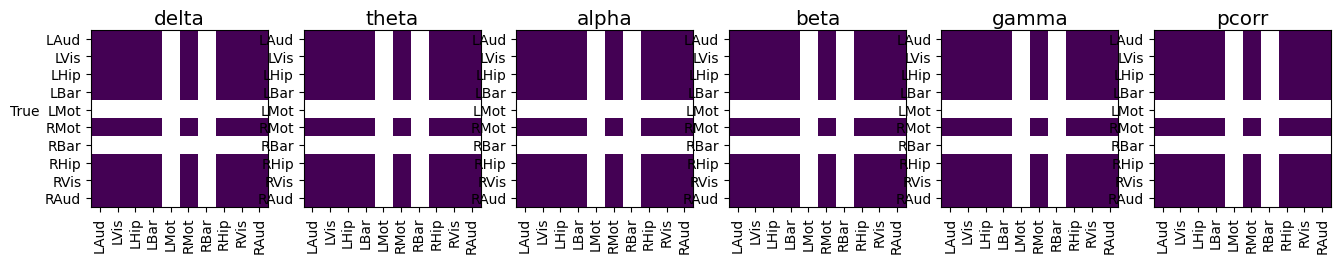

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:216: RuntimeWarning: Mean of empty slice
  data_Z = X - np.nanmean(X, axis=axis, keepdims=True)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:216: RuntimeWarning: Mean of empty slice
  data_Z = X - np.nanmean(X, axis=axis, keepdims=True)


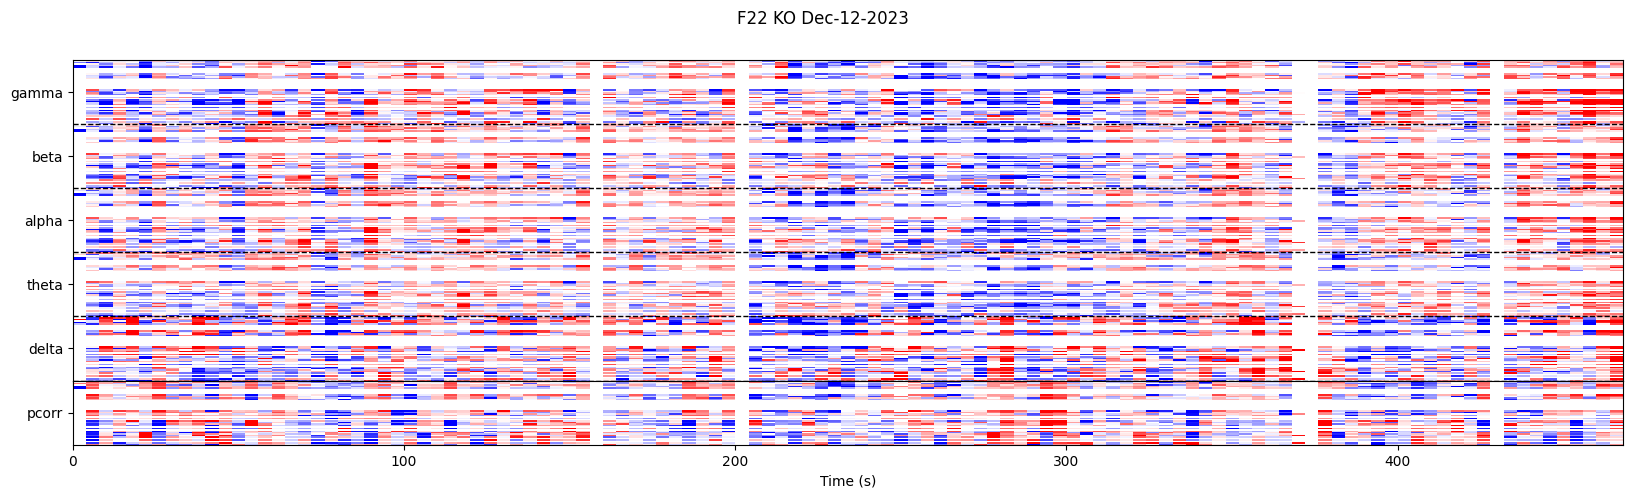

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:318: RuntimeWarning: divide by zero encountered in log10
  ax[0, i].plot(freqs, 10**(b + m * np.log10(freqs)), c=f'C{j}', alpha=0.75)


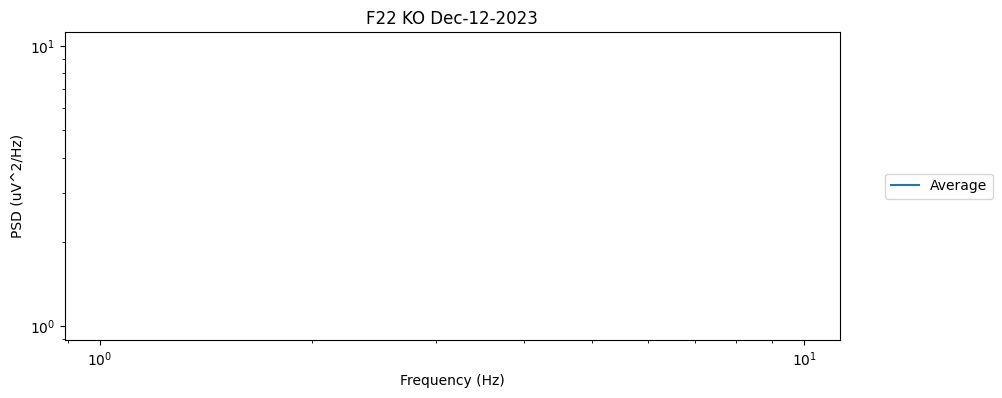

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/animal.py:335: RuntimeWarning: Mean of empty slice
  psd = np.nanmean(psd, axis=-1).transpose()


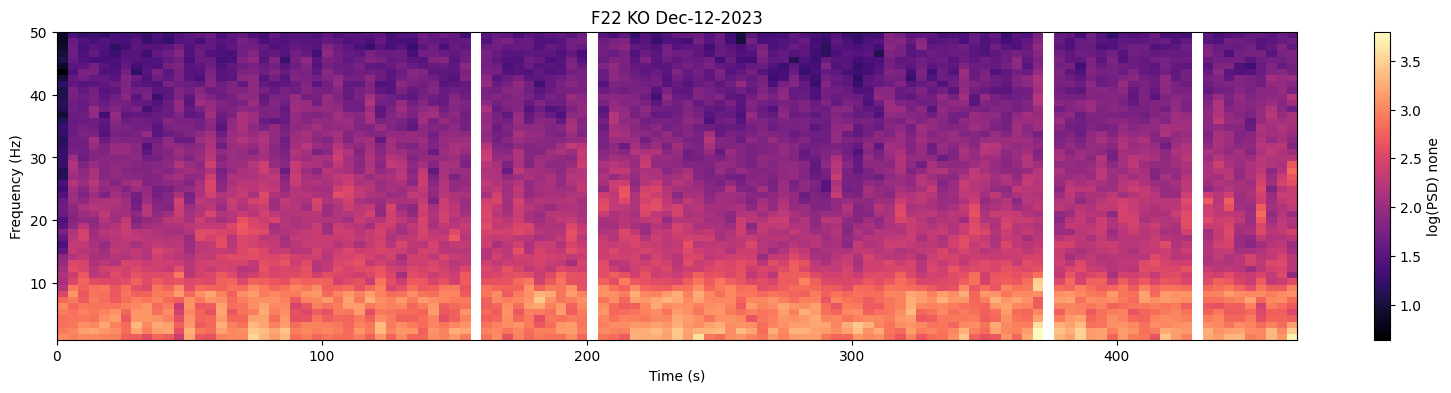

In [ ]:
logger.setLevel(logging.WARNING)
ap = visualization.AnimalPlotter(war)
ap.plot_coherecorr_matrix(['isday'], bands=None, figsize=(16,5), cmap='viridis')
# ap.plot_coherecorr_diff(['isday'], bands=None, figsize=(16,5))
# ap.plot_linear_temporal(figsize=(20, 5), score_type='z', lw=1, channels=[0, 1])
# ap.plot_linear_temporal(['isday'], figsize=(20, 5), score_type='z', lw=1, channels=[0, 1, 2, 3])

# ap.plot_coherecorr_spectral(['isday'], figsize=(20, 5), score_type='center')

ap.plot_coherecorr_spectral(figsize=(20, 5), score_type='center')
ap.plot_psd_histogram(figsize=(10, 4), avg_channels=True, plot_type='loglog')
ap.plot_psd_spectrogram(figsize=(20, 4), mode='none')

In [13]:
logger.setLevel(logging.DEBUG)
wars = []
animal_ids = ['A10', 'F22']
for i, animal_id in enumerate(animal_ids):
    war = visualization.WindowAnalysisResult.load_pickle_and_json(Path(f'./test-wars/{animal_id}').resolve())
    # logging.critical(war.result.iloc[0]['pcorr'])
    # war = war.filter_all()
    # logging.critical(war.result.iloc[0]['pcorr'])
    
    # wrangle = war.result.copy()
    war.filter_all(bad_channels=['LMot', 'RBar'])
    wars.append(war)
    
ep = visualization.ExperimentPlotter(wars,
                                     exclude=['nspike', 'logrms', 'logampvar', 'logpsdtotal', 'lognspike', 'logpsdband', 'logpsdfrac'])


2025-06-03 20:07:49,088 - WARNING - Intan Input (1)/PortC C-009 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,088 - WARNING - Intan Input (1)/PortC C-010 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,089 - WARNING - Intan Input (1)/PortC C-012 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,089 - WARNING - Intan Input (1)/PortC C-014 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,090 - WARNING - Intan Input (1)/PortC C-015 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,091 - WARNING - Intan Input (1)/PortC C-016 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,091 - WARNING - Intan Input (1)/PortC C-017 does not match name aliases. Assuming alias from number in channel name.
2025-06-03 20:07:49,091 - WARNING - Intan

In [14]:
# for feat in constants.LINEAR_FEATURE + ['psdband']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, 'animal')
#     # display(df)
#     # ep.plot_boxplot_2(feat, ['genotype', 'animalday'], collapse_channels=False)
#     ep.plot_catplot(feat, 'animal', kind='violin')

# ep.plot_catplot('psdband', ['animal', 'isday', 'animalday'], 
#                 x='animal',
#                 col='isday',
#                 hue='band',
#                 kind='boxen',
#                 collapse_channels=False,
#                 catplot_params={'showfliers': False})

In [15]:
# for feat in ['cohere']:
#     logging.info(f'pulling {feat}')
#     df = ep._pull_timeseries_dataframe(feat, ['animal', 'isday'])
#     ep.plot_2d_feature_2(feat, ['animal', 'isday'], row='band')

2025-06-03 20:07:49,433 - DEBUG - groups: [('A10 KO Dec-13-2023', True), ('F22 KO Dec-12-2023', True)]
2025-06-03 20:07:49,439 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:07:49,442 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:07:49,461 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:07:49,461 - DEBUG - vals.shape: (117, 5, 10, 10)


2025-06-03 20:07:49,722 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2148490b50>
2025-06-03 20:07:49,793 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2148314a00>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-06-03 20:07:50,093 - DEBUG - groups: ['A10 KO Dec-13-2023', 'F22 KO Dec-12-2023']
2025-06-03 20:07:50,095 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:07:50,096 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:07:50,102 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:07:50,103 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:07:50,668 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2148097b50>
2025-06-03 20:07:50,694 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2147f17940>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-06-03 20:07:50,908 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21480b3f40>
2025-06-03 20:07:50,940 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f218831d150>
2025-06-03 20:07:50,969 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21882adde0>
2025-06-03 20:07:51,003 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f218820f0d0>
2025-06-03 20:07:51,038 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f218816ffd0>
2025-06-03 20:07:51,089 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21883ecc10>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix

2025-06-03 20:07:51,134 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21903cd960>
2025-06-03 20:07:51,183 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21882787f0>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-06-03 20:07:52,027 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:52,028 - DEBUG - vals.shape: (31, 10, 10)
2025-06-03 20:07:52,031 - DEBUG - vals.shape: (117, 10, 10)
2025-06-03 20:07:52,101 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2168188580>
2025-06-03 20:07:52,195 - DEBUG - groups: ['KO']
2025-06-03 20:07:52,196 - DEBUG - vals.shape: (31, 10, 10)
2025-06-03 20:07:52,198 - DEBUG - vals.shape: (117, 10, 10)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-06-03 20:07:52,296 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21486b90f0>


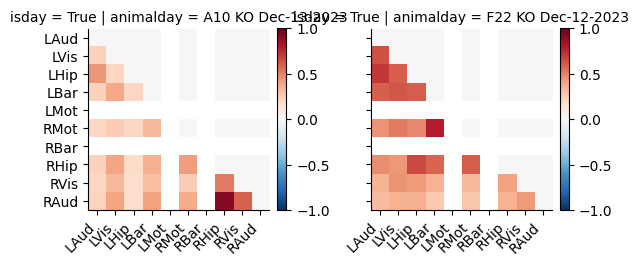

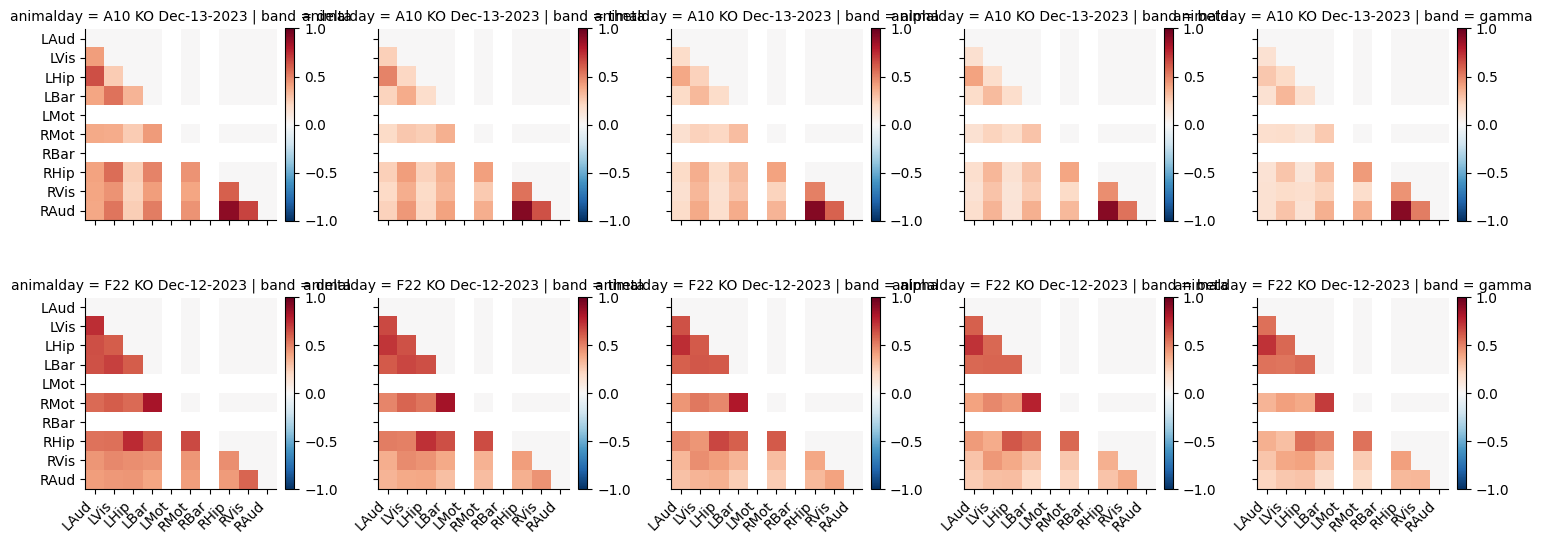

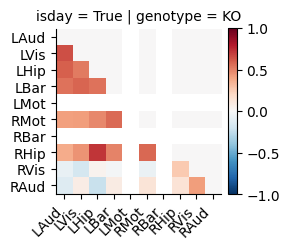

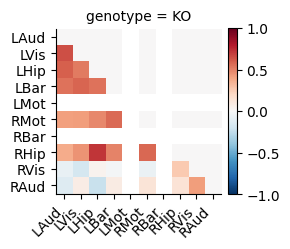

In [16]:
ep.plot_heatmap('cohere', groupby=['animalday', 'isday'])
ep.plot_heatmap('cohere', groupby='animalday', col='band', row='animalday')

ep.plot_heatmap('pcorr', groupby=['genotype', 'isday'])
ep.plot_heatmap('pcorr', groupby='genotype')

2025-06-03 20:07:54,978 - DEBUG - groups: ['KO']
2025-06-03 20:07:54,979 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:54,981 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:07:55,389 - DEBUG - groups: ['KO']
2025-06-03 20:07:55,390 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:55,392 - DEBUG - vals.shape: (117,)
2025-06-03 20:07:55,585 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:55,586 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:55,589 - DEBUG - vals.shape: (117, 10)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:55,973 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:55,977 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:55,982 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:56,209 - DEBUG - groups: ['KO']
2025-06-03 20:07:56,210 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:56,211 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:07:56,802 - DEBUG - groups: ['KO']
2025-06-03 20:07:56,803 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:56,807 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:57,116 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:57,117 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:57,120 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:07:57,560 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:57,561 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:57,563 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:57,799 - DEBUG - groups: ['KO']
2025-06-03 20:07:57,800 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:57,805 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:07:58,124 - DEBUG - groups: ['KO']
2025-06-03 20:07:58,126 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:58,128 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:58,593 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:58,597 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:58,599 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:07:58,975 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:58,976 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:58,985 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:59,230 - DEBUG - groups: ['KO']
2025-06-03 20:07:59,231 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:59,233 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:07:59,703 - DEBUG - groups: ['KO']
2025-06-03 20:07:59,704 - DEBUG - vals.shape: (31,)
2025-06-03 20:07:59,707 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:07:59,973 - DEBUG - groups: [('KO', True)]
2025-06-03 20:07:59,974 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:07:59,975 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:08:00,353 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:00,355 - DEBUG - vals.shape: (31,)
2025-06-03 20:08:00,360 - DEBUG - vals.shape: (117,)
2025-06-03 20:08:00,545 - DEBUG - groups: ['KO']
2025-06-03 20:08:00,546 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:08:00,548 - DEBUG - vals.shape: (117, 10)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:00,990 - DEBUG - groups: ['KO']
2025-06-03 20:08:00,993 - DEBUG - vals.shape: (31,)
2025-06-03 20:08:00,997 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:01,198 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:01,199 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:08:01,202 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:08:01,913 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:01,918 - DEBUG - vals.shape: (31,)
2025-06-03 20:08:01,922 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:02,274 - DEBUG - groups: ['KO']
2025-06-03 20:08:02,275 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:08:02,277 - DEBUG - vals.shape: (117, 10)


/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:453: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


2025-06-03 20:08:02,973 - DEBUG - groups: ['KO']
2025-06-03 20:08:02,974 - DEBUG - vals.shape: (31,)
2025-06-03 20:08:02,978 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:03,195 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:03,196 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:08:03,199 - DEBUG - vals.shape: (117, 10)
2025-06-03 20:08:03,792 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:03,794 - DEBUG - vals.shape: (31,)
2025-06-03 20:08:03,798 - DEBUG - vals.shape: (117,)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:04,182 - DEBUG - groups: ['KO']
2025-06-03 20:08:04,194 - DEBUG - vals.shape: (31, 10, 2)
2025-06-03 20:08:04,199 - DEBUG - vals.shape: (117, 10, 2)
2025-06-03 20:08:04,865 - DEBUG - groups: ['KO']
2025-06-03 20:08:04,868 - DEBUG - vals.shape: (31, 2)
2025-06-03 20:08:04,872 - DEBUG - vals.shape: (117, 2)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:05,252 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:05,254 - DEBUG - vals.shape: (31, 10, 2)
2025-06-03 20:08:05,261 - DEBUG - vals.shape: (117, 10, 2)
2025-06-03 20:08:06,365 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:06,368 - DEBUG - vals.shape: (31, 2)
2025-06-03 20:08:06,374 - DEBUG - vals.shape: (117, 2)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:06,868 - DEBUG - groups: ['KO']
2025-06-03 20:08:06,872 - DEBUG - vals.shape: (31, 10, 2)
2025-06-03 20:08:06,890 - DEBUG - vals.shape: (117, 10, 2)
2025-06-03 20:08:07,676 - DEBUG - groups: ['KO']
2025-06-03 20:08:07,677 - DEBUG - vals.shape: (31, 2)
2025-06-03 20:08:07,691 - DEBUG - vals.shape: (117, 2)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:08,070 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:08,074 - DEBUG - vals.shape: (31, 10, 2)
2025-06-03 20:08:08,077 - DEBUG - vals.shape: (117, 10, 2)
2025-06-03 20:08:08,814 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:08,817 - DEBUG - vals.shape: (31, 2)
2025-06-03 20:08:08,820 - DEBUG - vals.shape: (117, 2)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


Skipping feature nspike
Skipping feature logrms
Skipping feature logampvar
Skipping feature logpsdtotal
Skipping feature lognspike
2025-06-03 20:08:09,152 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:09,156 - DEBUG - vals.shape: (31, 5)
2025-06-03 20:08:09,160 - DEBUG - vals.shape: (117, 5)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:09,503 - DEBUG - groups: ['KO']
2025-06-03 20:08:09,504 - DEBUG - vals.shape: (31, 5)
2025-06-03 20:08:09,508 - DEBUG - vals.shape: (117, 5)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:09,864 - DEBUG - groups: [('KO', True)]
2025-06-03 20:08:09,868 - DEBUG - vals.shape: (31, 5)
2025-06-03 20:08:09,870 - DEBUG - vals.shape: (117, 5)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


2025-06-03 20:08:10,328 - DEBUG - groups: ['KO']
2025-06-03 20:08:10,332 - DEBUG - vals.shape: (31, 5)
2025-06-03 20:08:10,336 - DEBUG - vals.shape: (117, 5)


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:157: RuntimeWarning: Mean of empty slice
  vals = np.nanmean(vals, axis=1)


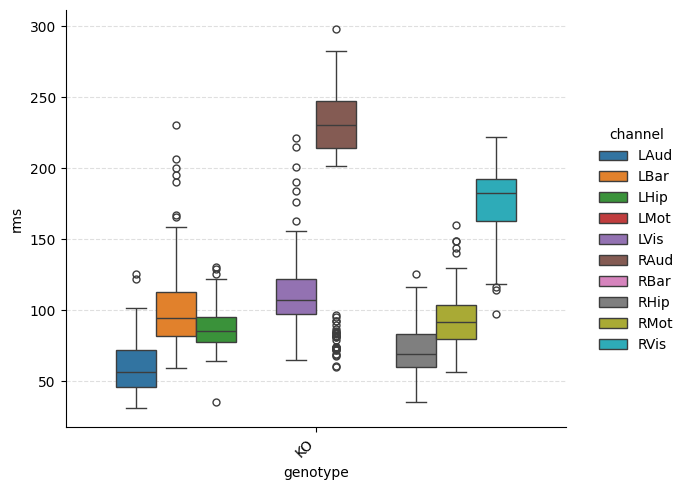

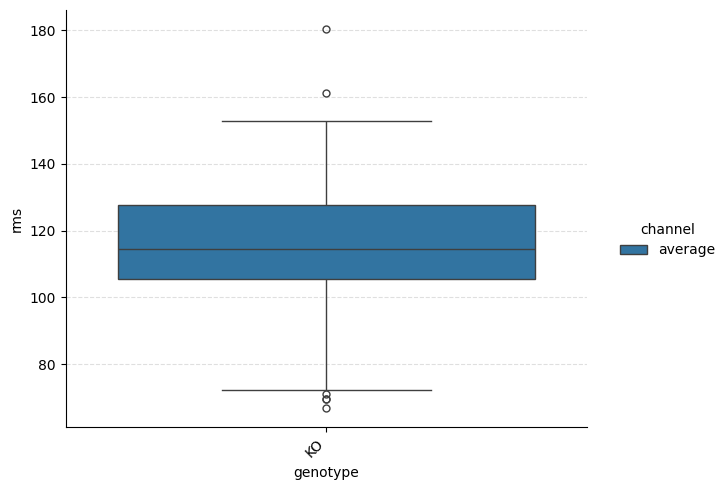

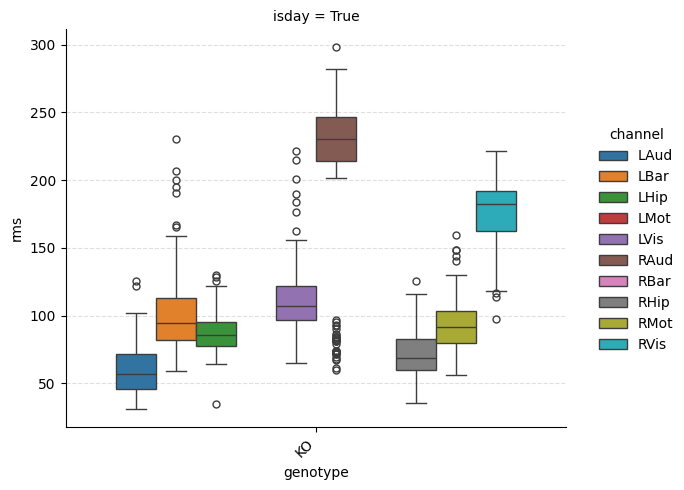

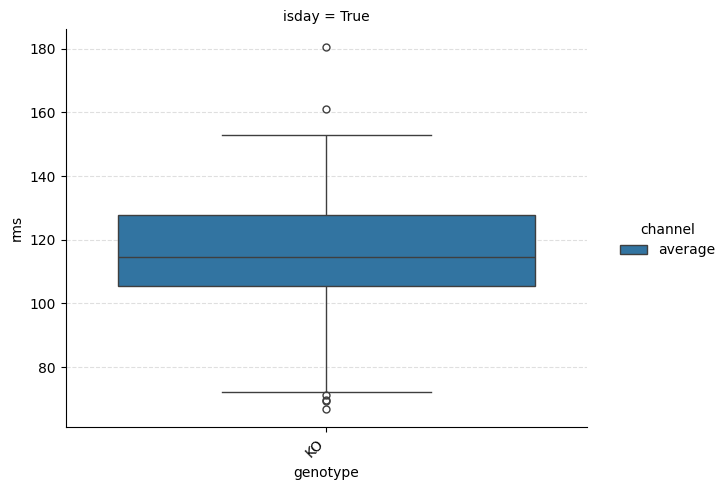

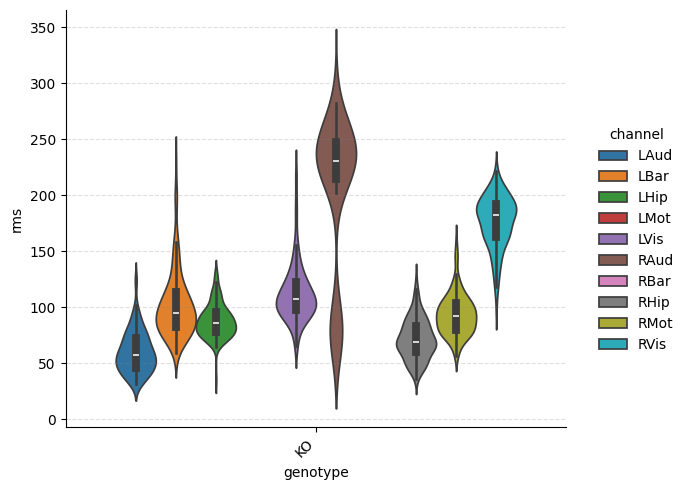

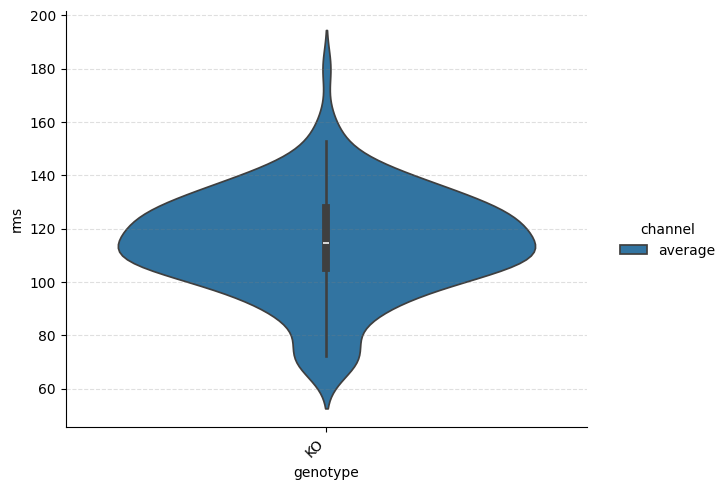

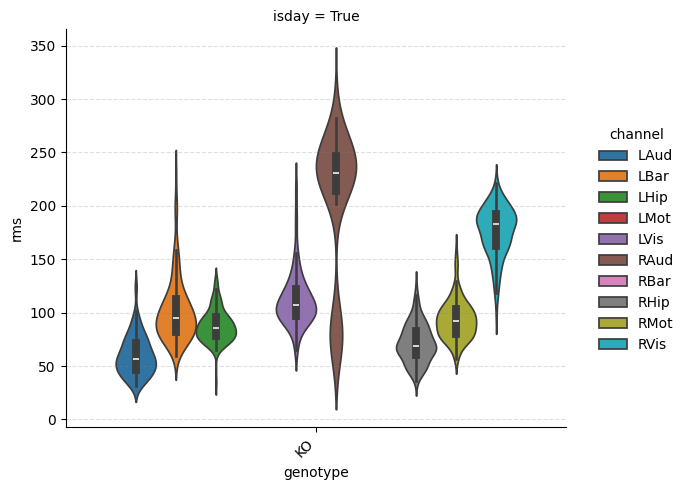

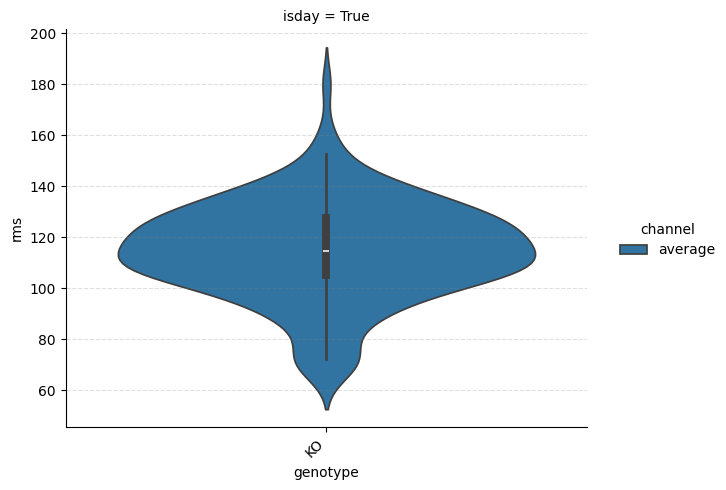

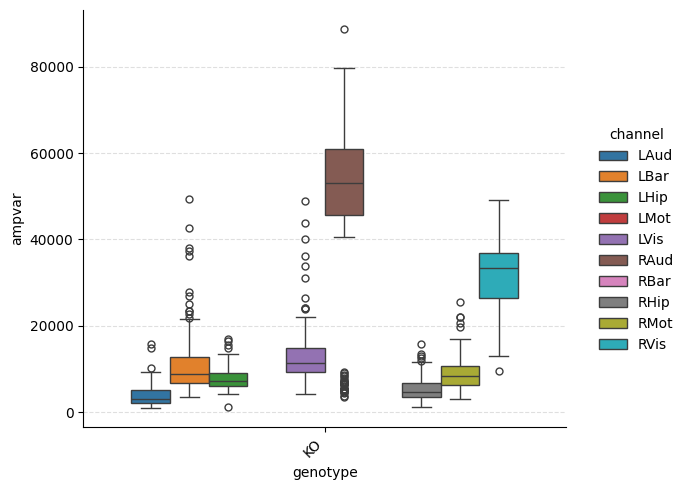

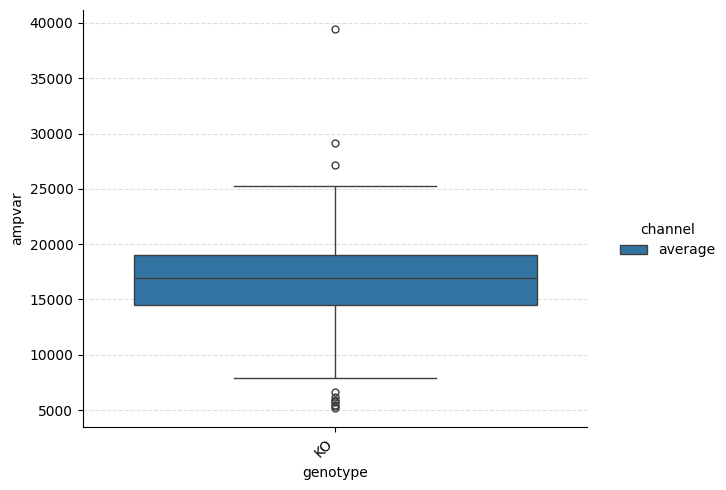

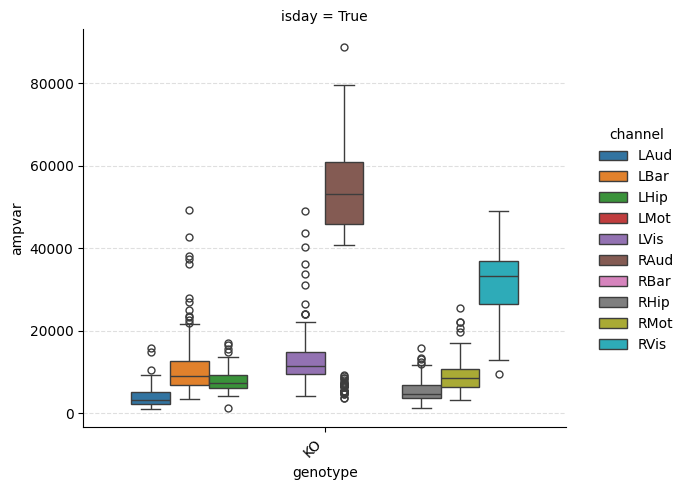

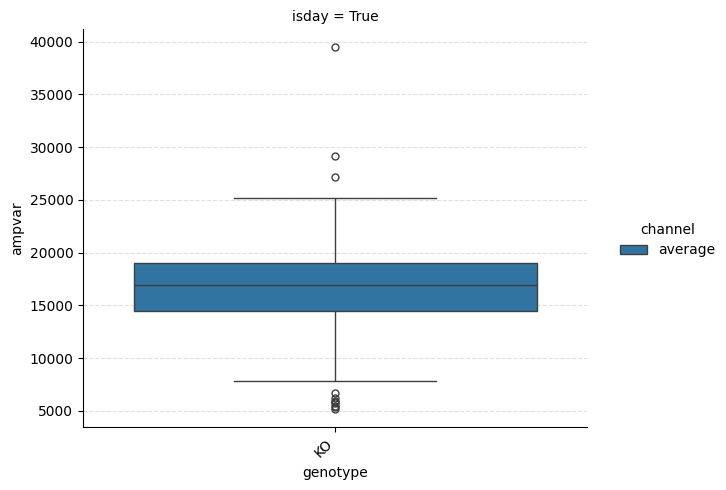

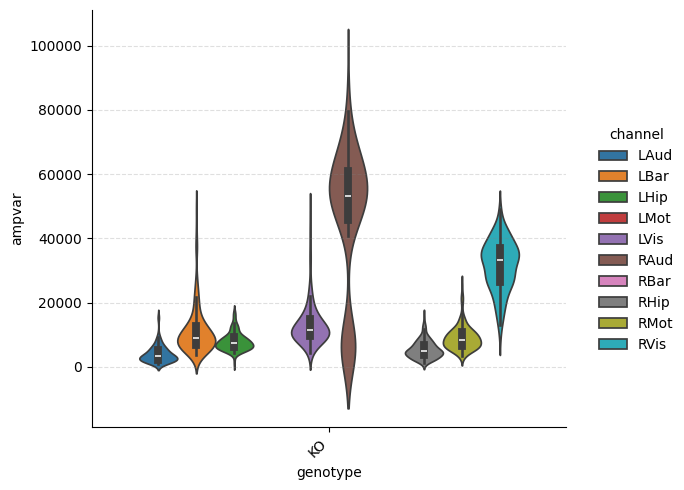

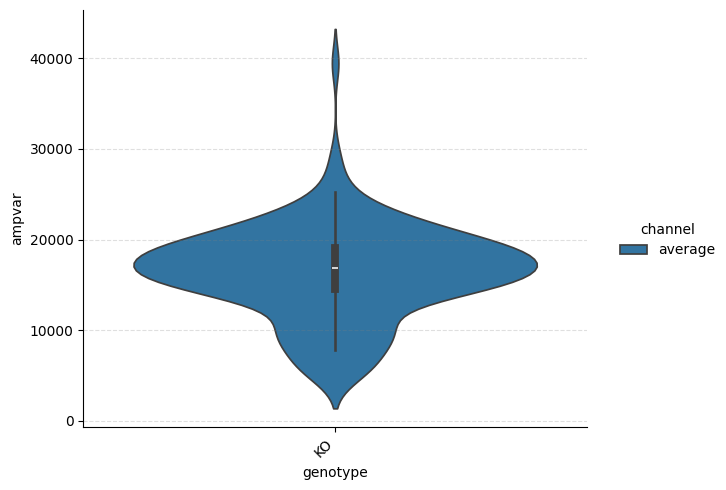

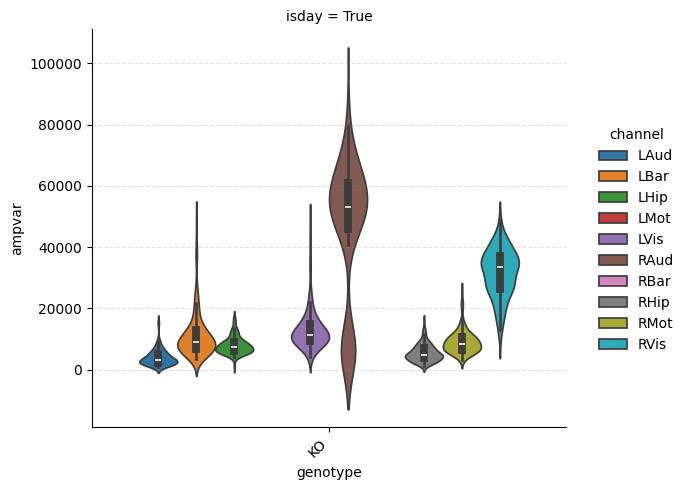

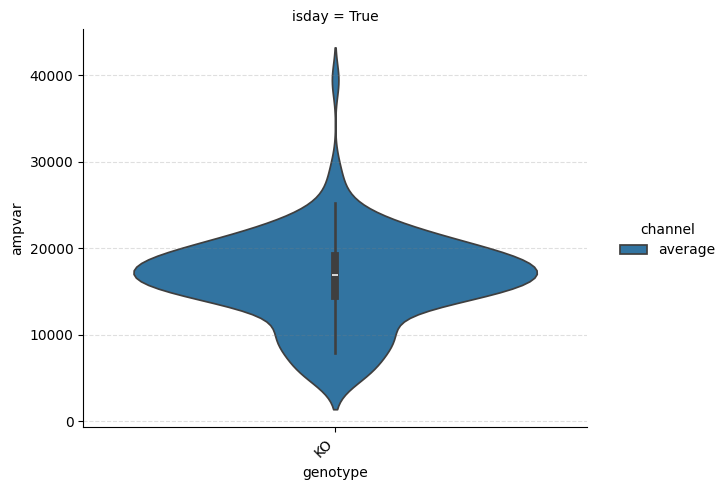

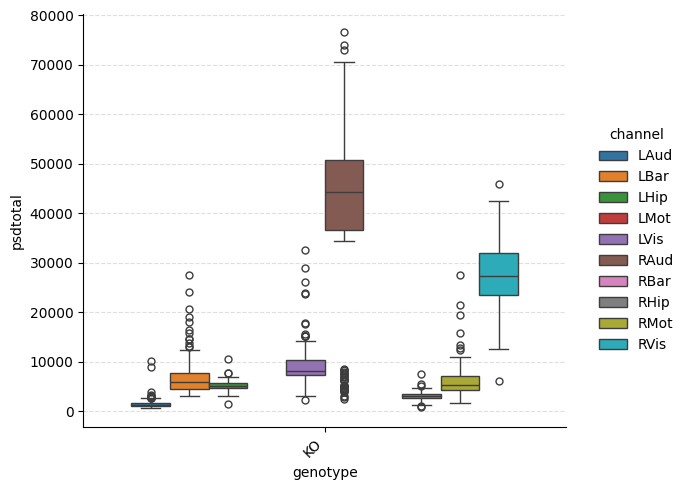

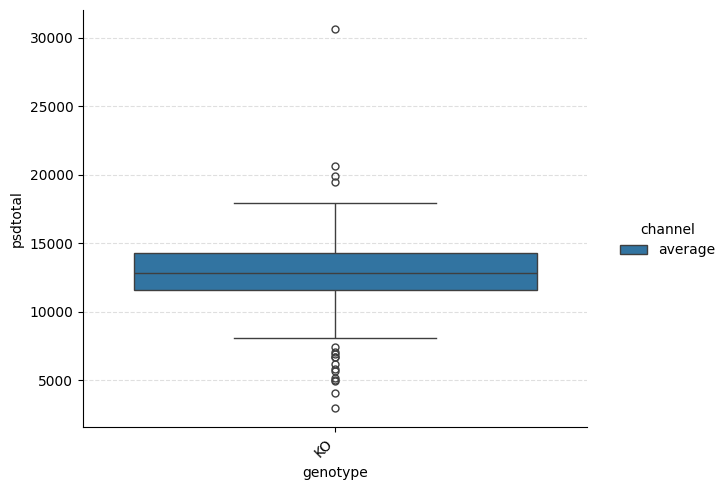

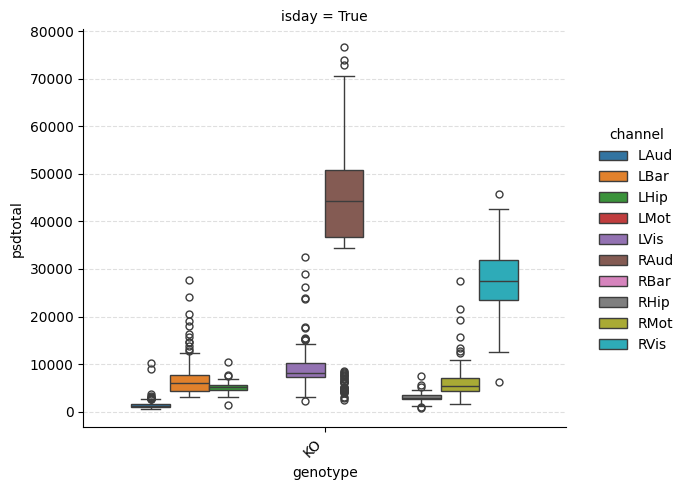

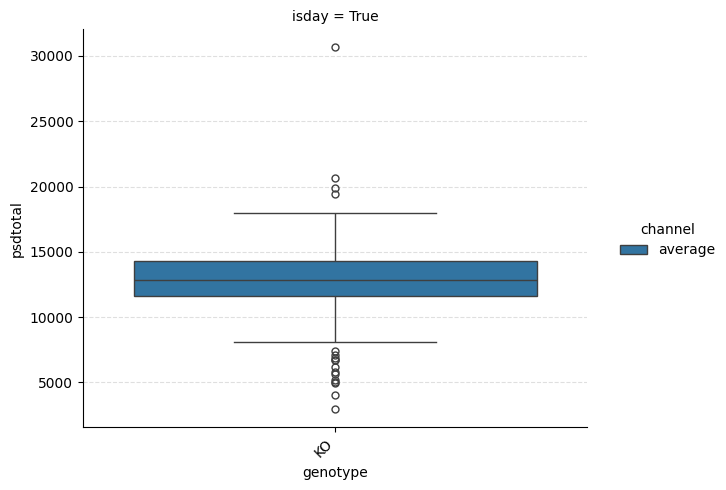

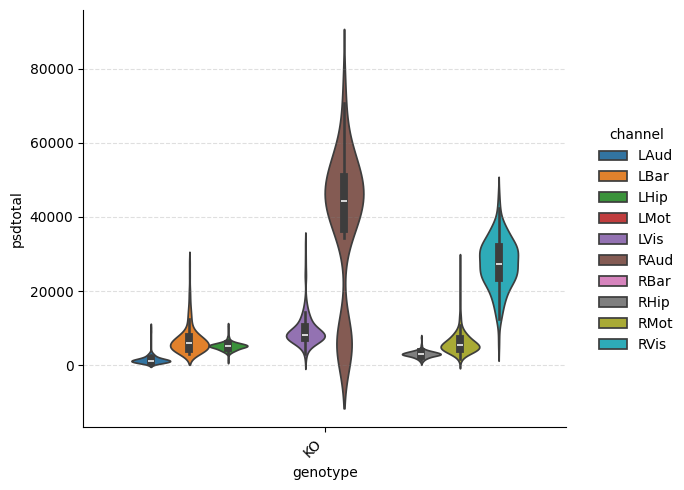

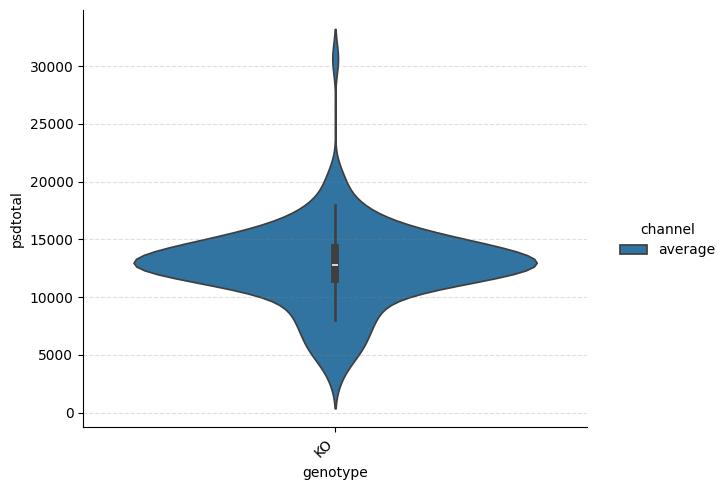

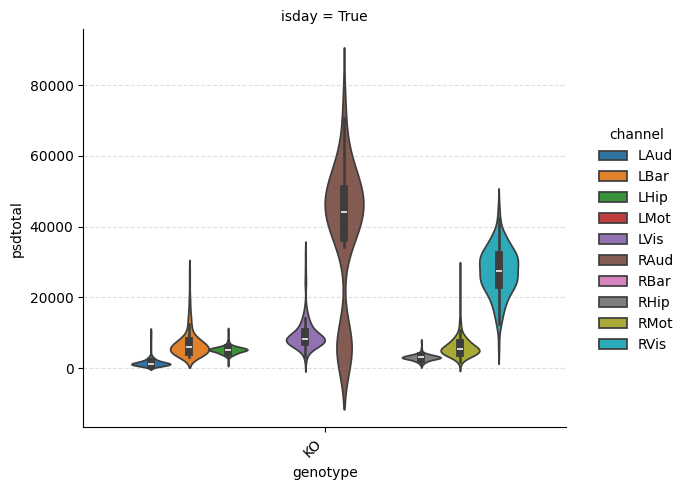

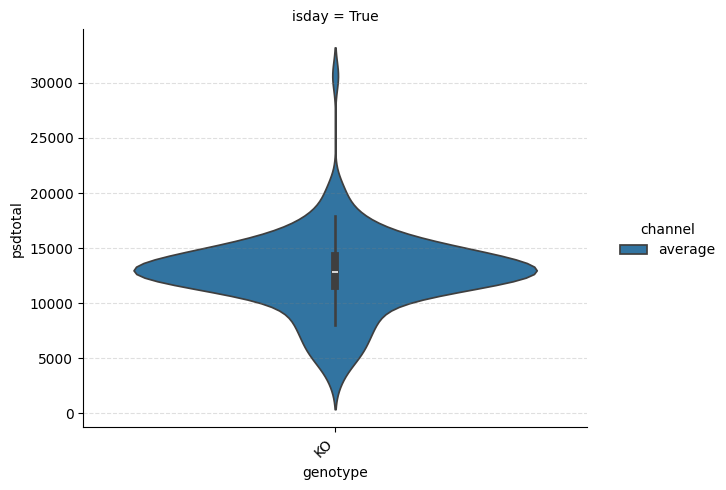

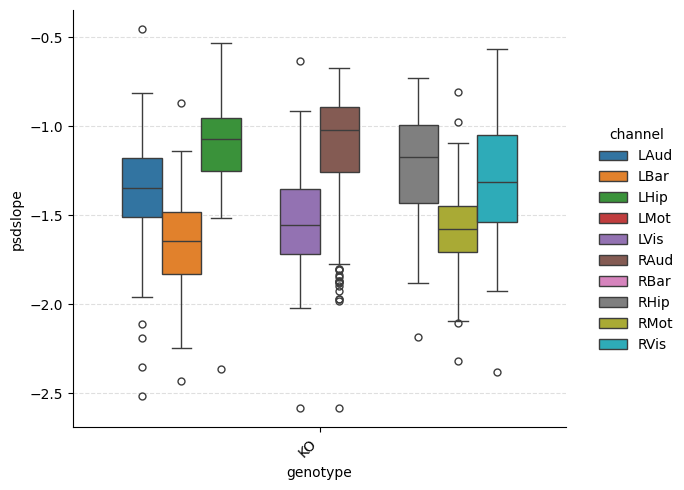

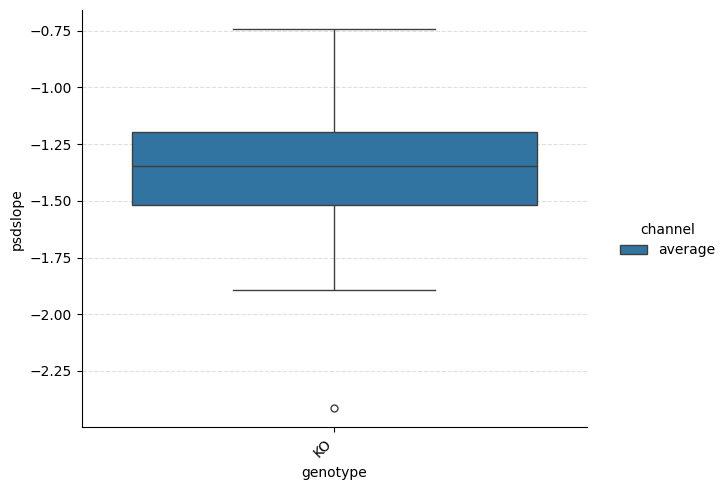

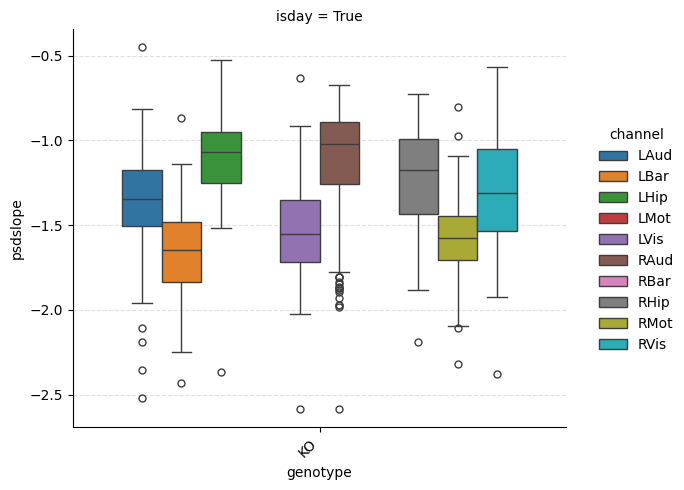

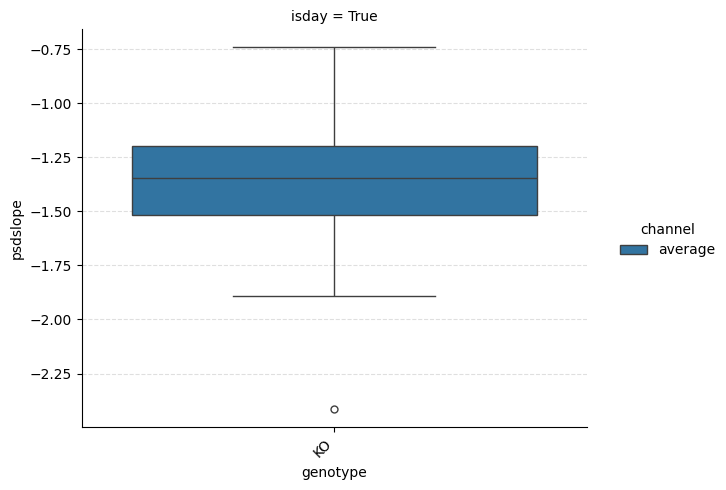

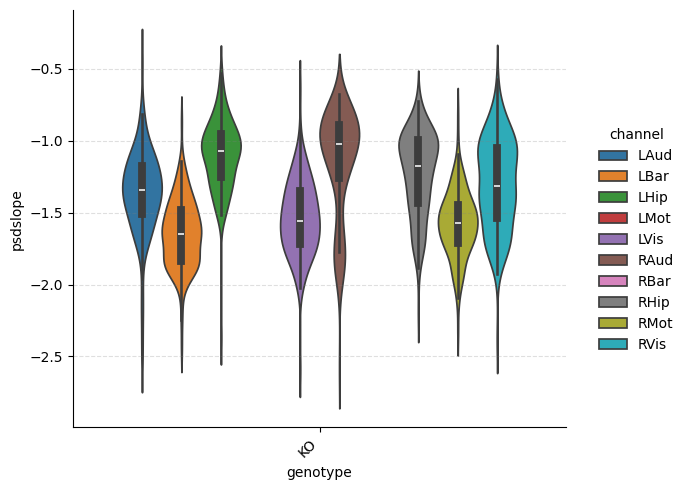

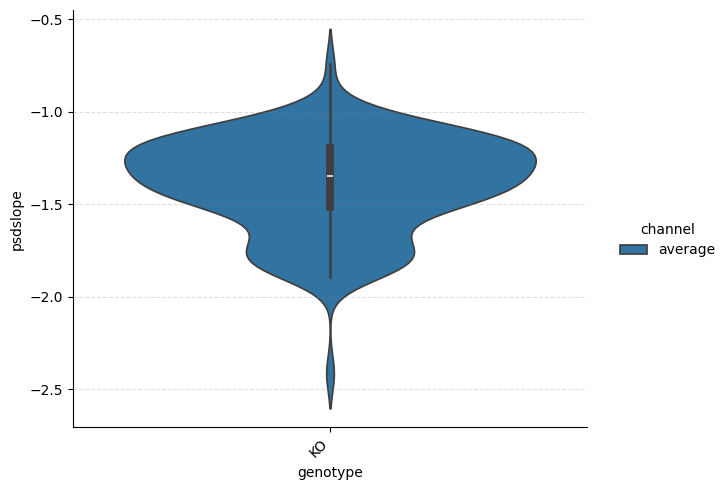

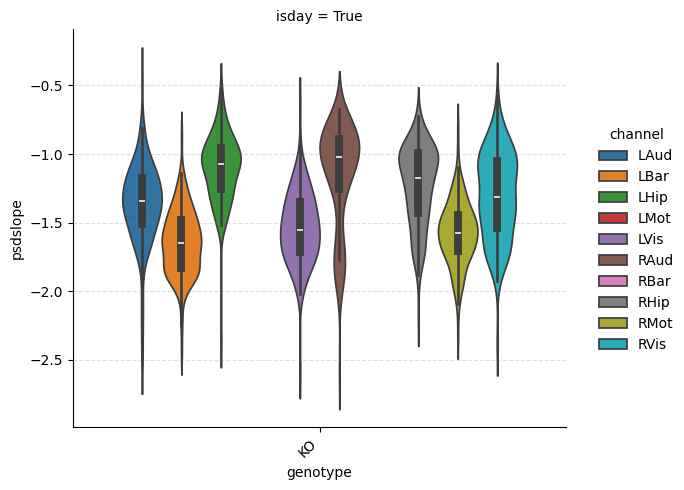

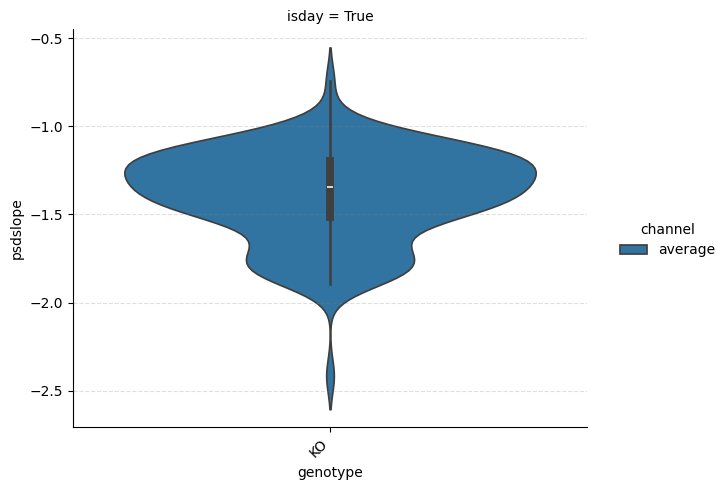

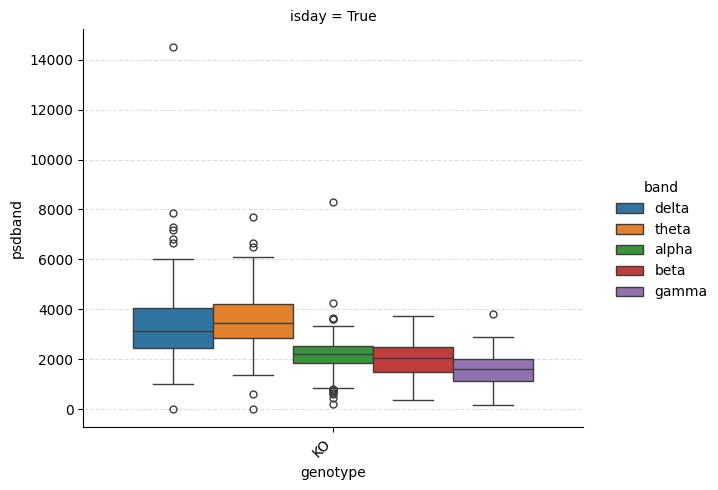

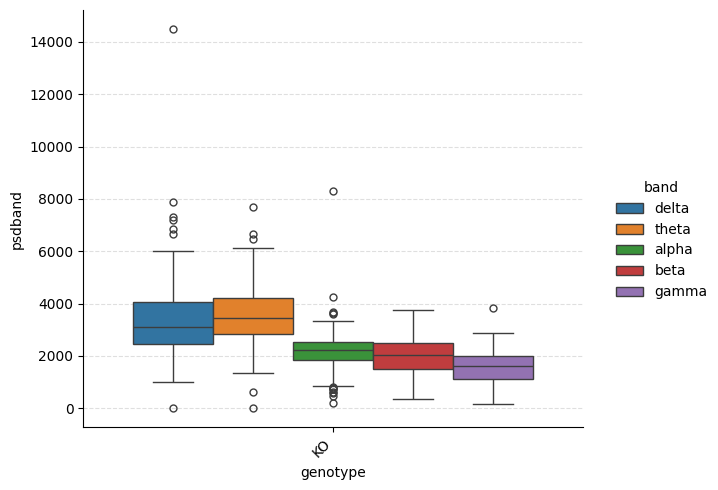

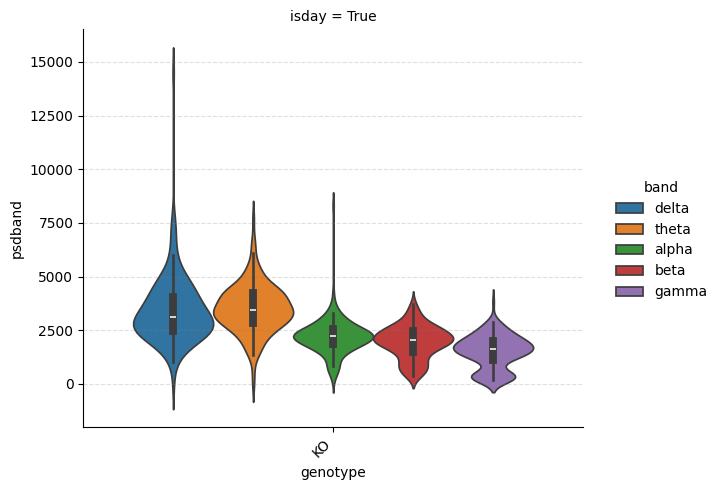

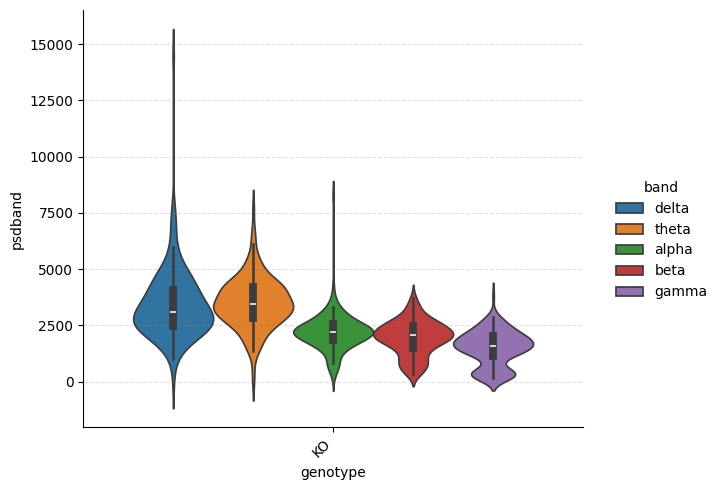

In [17]:
for feature in constants.LINEAR_FEATURES:
    if feature in ['nspike', 'logrms', 'logampvar', 'logpsdtotal', 'lognspike', 'logpsdband', 'logpsdfrac']:
        print(f"Skipping feature {feature}")
        continue
    for kind in ['box', 'violin']:
        for groupby in ['genotype', ['genotype', 'isday']]:
            for collapse in [False, True]:
                ep.plot_catplot(feature, groupby=groupby, kind=kind, collapse_channels=collapse)
for kind in ['box', 'violin']:
    ep.plot_catplot('psdband', groupby=['genotype', 'isday'], 
                    x='genotype',
                    col='isday',
                    hue='band',
                    kind=kind, collapse_channels=True)
    ep.plot_catplot('psdband', groupby=['genotype'], 
                    x='genotype',
                    hue='band',
                    kind=kind, collapse_channels=True)

2025-06-03 20:08:16,463 - DEBUG - groups: ['A10', 'F22']
2025-06-03 20:08:16,464 - DEBUG - vals.shape: (31, 10)
2025-06-03 20:08:16,467 - DEBUG - vals.shape: (117, 10)


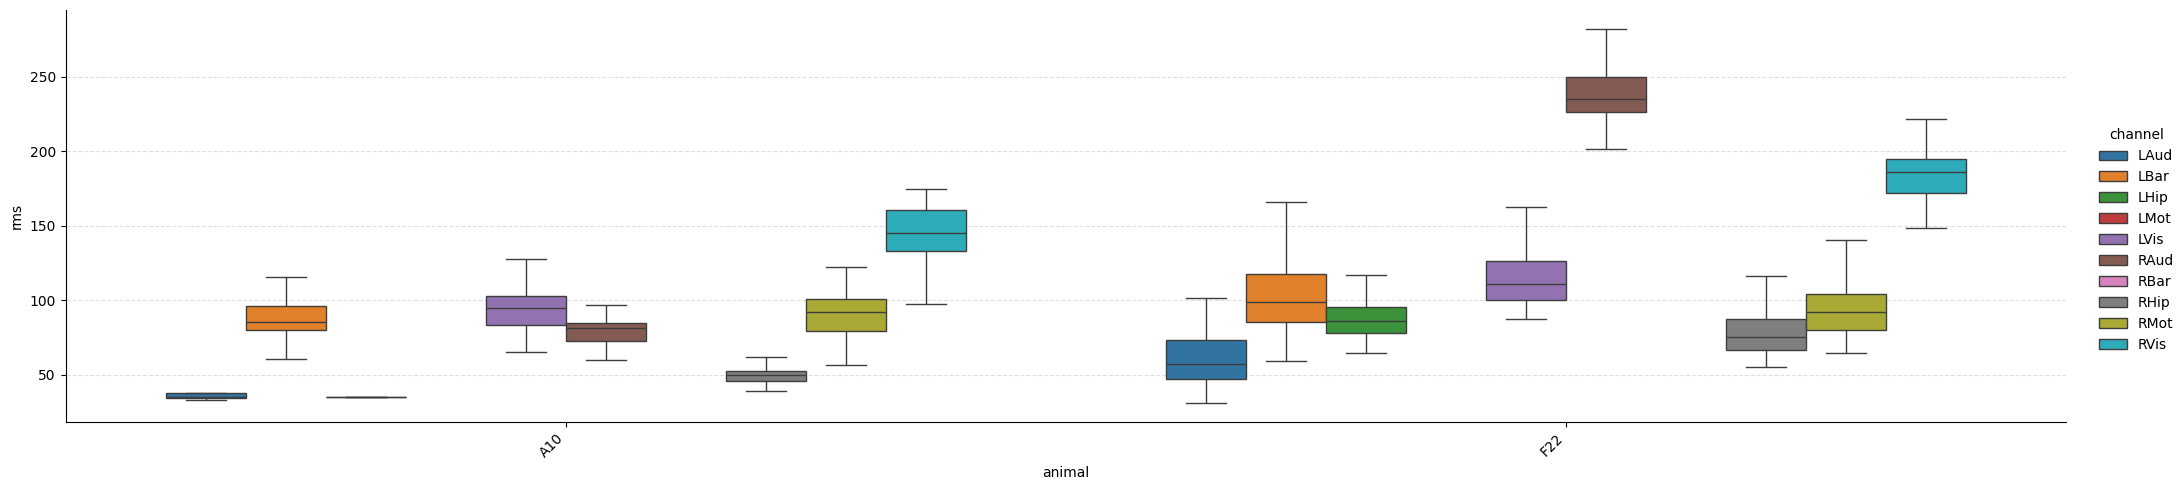

In [18]:
ep.plot_catplot('rms', groupby='animal', kind='box', catplot_params={'showfliers': False, 'aspect': 4})

2025-06-03 20:08:17,084 - DEBUG - groups: ['A10', 'F22']
2025-06-03 20:08:17,089 - DEBUG - vals.shape: (31, 10, 10)
2025-06-03 20:08:17,093 - DEBUG - vals.shape: (117, 10, 10)
2025-06-03 20:08:17,235 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2146658df0>
2025-06-03 20:08:17,262 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f21466f8d30>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


2025-06-03 20:08:17,464 - DEBUG - groups: ['A10', 'F22']
2025-06-03 20:08:17,466 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:08:17,467 - DEBUG - vals.shape: (31, 5, 10, 10)
2025-06-03 20:08:17,472 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:08:17,473 - DEBUG - vals.shape: (117, 5, 10, 10)
2025-06-03 20:08:18,104 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145f6e5f0>
2025-06-03 20:08:18,132 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145fbfac0>
2025-06-03 20:08:18,161 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145e21f00>
2025-06-03 20:08:18,188 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145e6f940>
2025-06-03 20:08:18,215 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145ecdba0>
2025-06-03 20:08:18,242 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145d1fdc0>
2025-06-03 20:08:18,269 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145d

/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix

2025-06-03 20:08:18,301 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2145dd3640>
2025-06-03 20:08:18,697 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f2146e43070>
2025-06-03 20:08:18,723 - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f214723b190>


/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)
/mnt/isilon/marsh_single_unit/PythonEEG/pythoneeg/visualization/plotting/experiment.py:415: RuntimeWarning: Mean of empty slice
  avg_matrix = np.nanmean(matrices, axis=0)


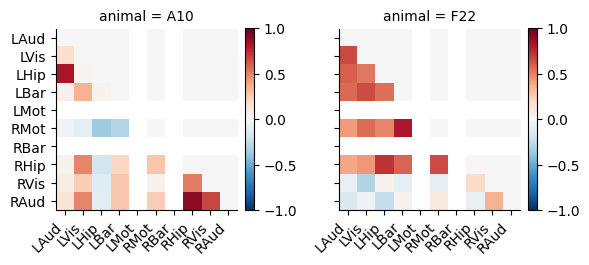

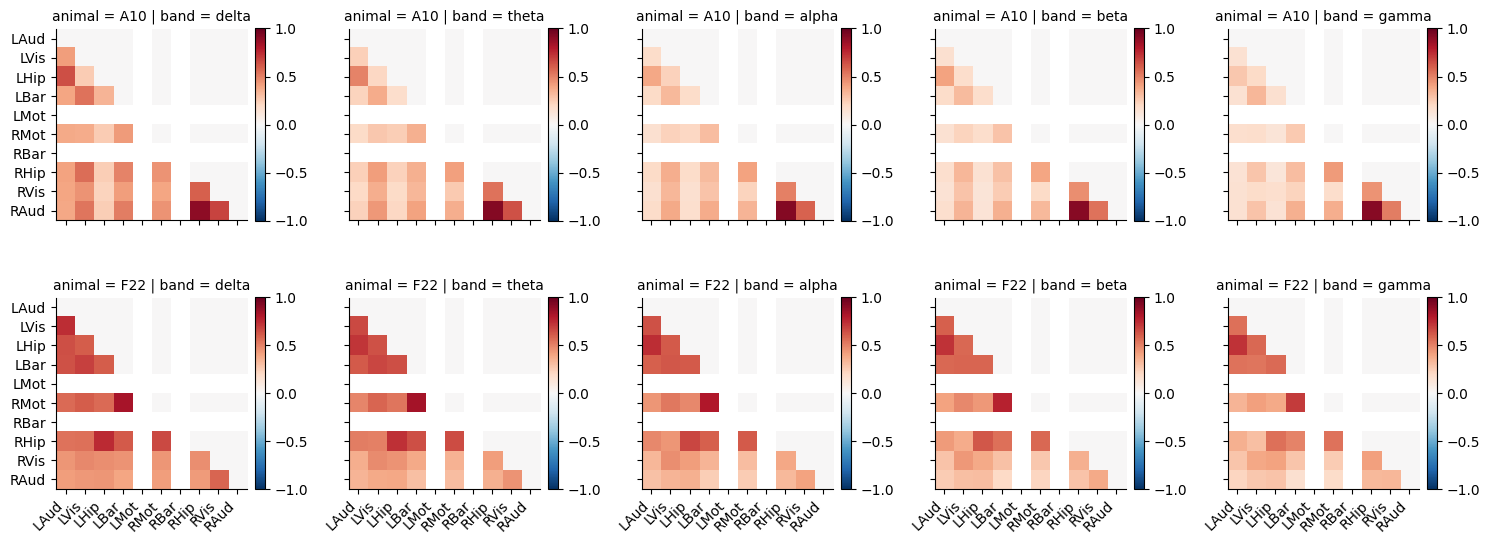

In [19]:
ep.plot_heatmap('pcorr', groupby='animal')
ep.plot_heatmap('cohere', groupby='animal', col='band', row='animal')

In [20]:
logger.setLevel(logging.DEBUG)

In [21]:
for e in sar:
    e.convert_to_mne(chunk_len=1440)
    e.save_fif_and_json(Path(f'./test-mnes/{e.animal_day}').resolve(), overwrite=True)

NameError: name 'sar' is not defined

In [17]:
reconstruct_sas = visualization.SpikeAnalysisResult.load_fif_and_json('./test-mnes/A5 WT Dec-12-2023')
mne_obj = reconstruct_sas.result_mne

Opening raw data file test-mnes/A5 WT Dec-12-2023/A5-WT-A5 WT Dec-12-2023-raw.fif...
    Reading extended channel information
Isotrak not found
    Range : 0 ... 40067758 =      0.000 ... 40067.758 secs
Ready.
2025-03-21 21:23:35,173 - INFO - Channel names: 	['Intan Input (1)/PortB L Aud Ctx', 'Intan Input (1)/PortB L Vis Ctx', 'Intan Input (1)/PortB L Hipp', 'Intan Input (1)/PortB L Barrel', 'Intan Input (1)/PortB L Motor', 'Intan Input (1)/PortB R Motor', 'Intan Input (1)/PortB R Barrel', 'Intan Input (1)/PortB R Hipp', 'Intan Input (1)/PortB R Vis Ctx', 'Intan Input (1)/PortB R Aud Ctx']
2025-03-21 21:23:35,174 - INFO - Channel abbreviations: 	['LAud', 'LVis', 'LHip', 'LBar', 'LMot', 'RMot', 'RBar', 'RHip', 'RVis', 'RAud']


Used Annotations descriptions: [np.str_('Intan Input (1)/PortB L Aud Ctx'), np.str_('Intan Input (1)/PortB L Barrel'), np.str_('Intan Input (1)/PortB L Hipp'), np.str_('Intan Input (1)/PortB L Motor'), np.str_('Intan Input (1)/PortB L Vis Ctx'), np.str_('Intan Input (1)/PortB R Aud Ctx'), np.str_('Intan Input (1)/PortB R Barrel'), np.str_('Intan Input (1)/PortB R Hipp'), np.str_('Intan Input (1)/PortB R Motor'), np.str_('Intan Input (1)/PortB R Vis Ctx')]


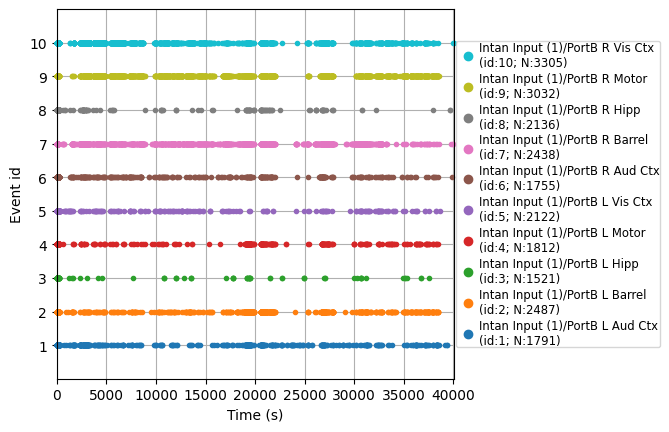

In [18]:
logger.setLevel(logging.WARNING)
events, event_id = mne.events_from_annotations(raw=mne_obj)
fig = mne.viz.plot_events(events, sfreq=mne_obj.info['sfreq'], first_samp=mne_obj.first_samp, event_id=event_id)